In [1]:
import avocado
from avocado.instruments import get_band_plot_color, get_band_plot_marker
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
main_path = os.path.abspath(os.path.join(os.path.dirname("data_augmentation.ipynb"), ".."))
sys.path.insert(0, main_path)
from src.avocado_adapter import PlasticcAugmentor

In [2]:
plasticc_train = avocado.load("plasticc_train", metadata_only=False)
print(plasticc_train.metadata.columns)
plasticc_train.metadata.shape

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic'],
      dtype='object')


(7848, 24)

In [3]:
# get kilonova objects
df = plasticc_train.metadata
df = df[df["class"]==64]
df = df[df["ddf"] == 1]
idxs = df.index.to_numpy()

In [4]:
# show detections number:
for i in idxs:
    obj_i = plasticc_train.get_object(object_id=i)
    print("dectections object '%s':" % i, np.sum(obj_i.observations["detected"].to_numpy()))

dectections object 'plasticc_000062187': 3
dectections object 'plasticc_000139362': 6


In [30]:
def plot_light_curve(ref, show_gp=True, only_detections=True, computed_gp=None, verbose=False, axis=None, set_plot=True, **kwargs):
    if verbose:
        ref.print_metadata()
        
    if show_gp:
        if computed_gp is not None:
            gp = computed_gp
            observations = ref.preprocess_observations(**kwargs)
        else:
            gp, observations, gp_fit_parameters = ref.fit_gaussian_process(verbose=verbose, **kwargs)
    else:
        observations = ref.preprocess_observations(**kwargs)
        
    min_time_obs = np.min(observations["time"])
    max_time_obs = np.max(observations["time"])
    border = 0.1 * (max_time_obs - min_time_obs)
    min_time = min_time_obs - border
    max_time = max_time_obs + border
    
    if show_gp:
        pred_times = np.arange(min_time, max_time + 1)
        predictions, prediction_uncertainties = ref.predict_gaussian_process(
                ref.bands, pred_times, fitted_gp=gp
            )
    
    if axis is None:
        figure, axis = plt.subplots()
    
    if only_detections:
        mask0 = observations["detected"] == 1
        observations = observations[mask0]
        
    for band_idx, band in enumerate(ref.bands):
        mask = observations["band"] == band
        band_data = observations[mask]
        color = get_band_plot_color(band)
        marker = get_band_plot_marker(band)
        if not band_data.empty:
            axis.errorbar(
                band_data["time"],
                band_data["flux"],
                band_data["flux_error"],
                fmt="o",
                c=color,
                markersize=6,
                marker=marker,
                label=band,
            )
        
        if not show_gp:
                continue
                
        pred = predictions[band_idx]
        axis.plot(pred_times, pred, c=color, alpha=0.5)
        err = prediction_uncertainties[band_idx]

        if kwargs.get("uncertainties", True):
                # If they were calculated, show uncertainties with a shaded
                # band.
            axis.fill_between(
                pred_times, pred - err, pred + err, alpha=0.2, color=color
                )
    if set_plot:
        axis.legend()

        axis.set_xlabel("Time (days)")
        axis.set_ylabel("Flux")
        axis.set_xlim(min_time, max_time)
        axis.figure.tight_layout()
        
        
def augment_examples(plasticc_train, idx, custom_detections=False):
    augmentor = PlasticcAugmentor()
    obj1 = plasticc_train.get_object(object_id=idx)
    ts = [obj1] + [augmentor.augment_object(obj1, force_success=True, custom_detections=custom_detections) for _ in range(3)]
    gp, _, _ = obj1.fit_gaussian_process(verbose=False)
    
    n1 = 2
    n2 = 2
    fig, ax = plt.subplots(n1, n2, figsize=(15, 7), sharex=True, sharey=True)
    k = 0
    for i in range(n1):
        for j in range(n2):
            plot_light_curve(ts[k], axis=ax[i][j], set_plot=False, computed_gp=gp, only_detections=False, uncertainties=True)
            ax[i][j].set_title("'%s', %d detections, redshift %0.2f" % (ts[k].metadata["object_id"], np.sum(ts[k].observations["detected"].to_numpy()), ts[k].metadata["redshift"]))
            ax[i][j].legend()
            k += 1
        
    plt.tight_layout()
    
    n1 = 2
    n2 = 2
    fig, ax = plt.subplots(n1, n2, figsize=(15, 7), sharex=True, sharey=True)
    k = 0
    for i in range(n1):
        for j in range(n2):
            plot_light_curve(ts[k], axis=ax[i][j], set_plot=False, computed_gp=gp, only_detections=True, uncertainties=k==0)
            ax[i][j].set_title("'%s', %d detections, redshift %0.2f" % (ts[k].metadata["object_id"], np.sum(ts[k].observations["detected"].to_numpy()), ts[k].metadata["redshift"]))
            ax[i][j].legend()
            k += 1
        
    plt.tight_layout()
    
    n1 = 2
    n2 = 2
    fig, ax = plt.subplots(n1, n2, figsize=(15, 7), sharex=True, sharey=True)
    k = 0
    for i in range(n1):
        for j in range(n2):
            plot_light_curve(ts[k], axis=ax[i][j], set_plot=False, computed_gp=None, only_detections=True, uncertainties=True)
            ax[i][j].set_title("'%s', %d detections, redshift %0.2f" % (ts[k].metadata["object_id"], np.sum(ts[k].observations["detected"].to_numpy()), ts[k].metadata["redshift"]))
            ax[i][j].legend()
            k += 1
        
    plt.tight_layout()

## data augmentation using kilonova 'plasticc_000062187'

using num_detection=2 as default in PLaSTiCC

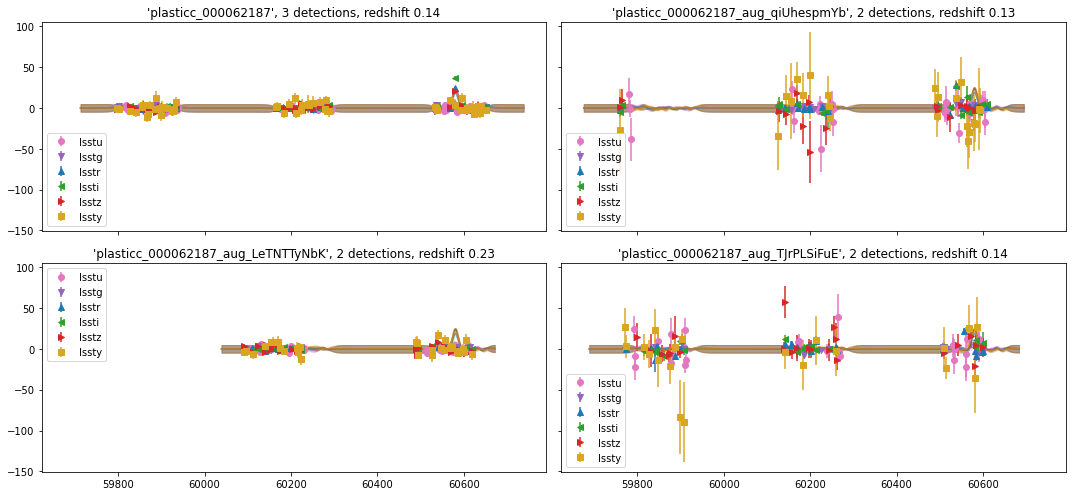

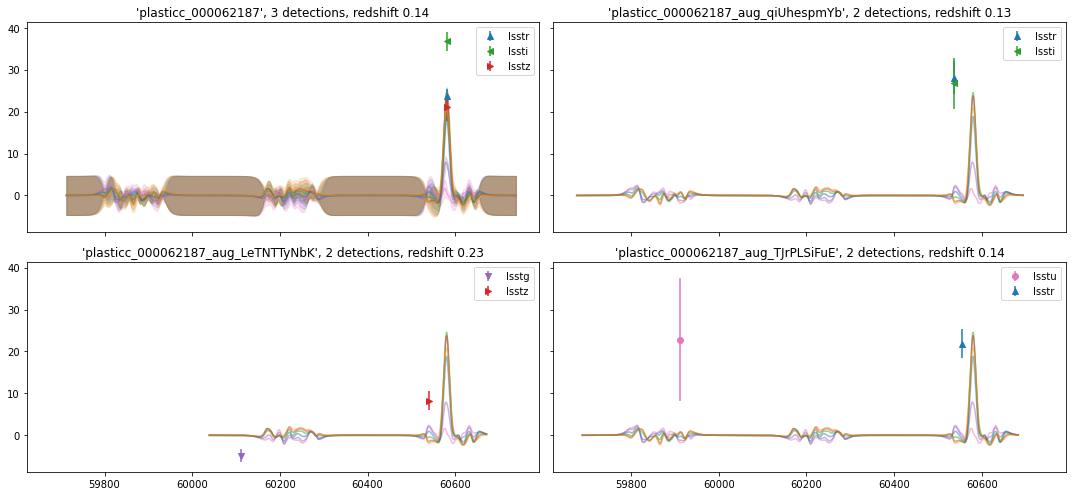

In [24]:
augment_examples(plasticc_train, idxs[0], custom_detections=False)

using num_detections=custom defined by the original time series from where we generate new

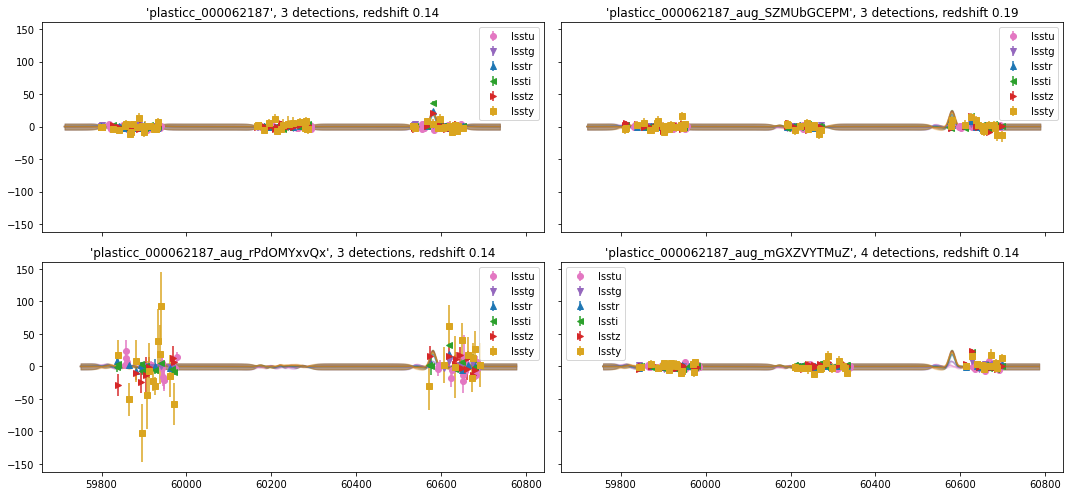

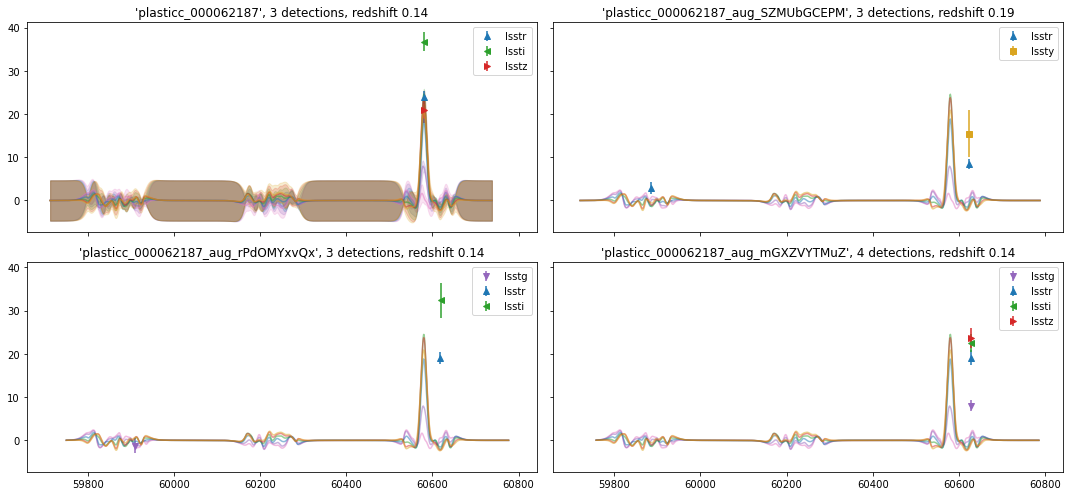

In [25]:
augment_examples(plasticc_train, idxs[0], custom_detections=True)

## data augmentation using kilonova 'plasticc_000139362'

using num_detection=2 as default in PLaSTiCC

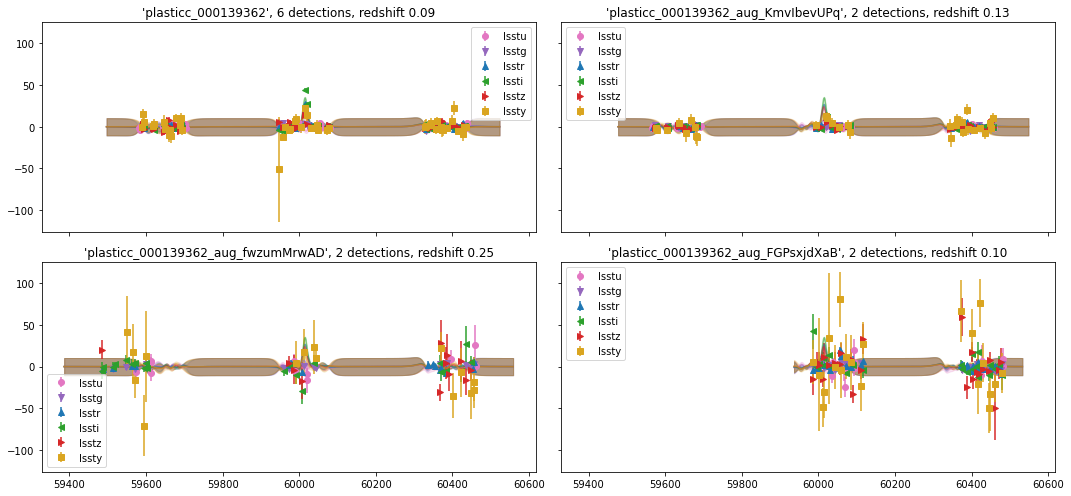

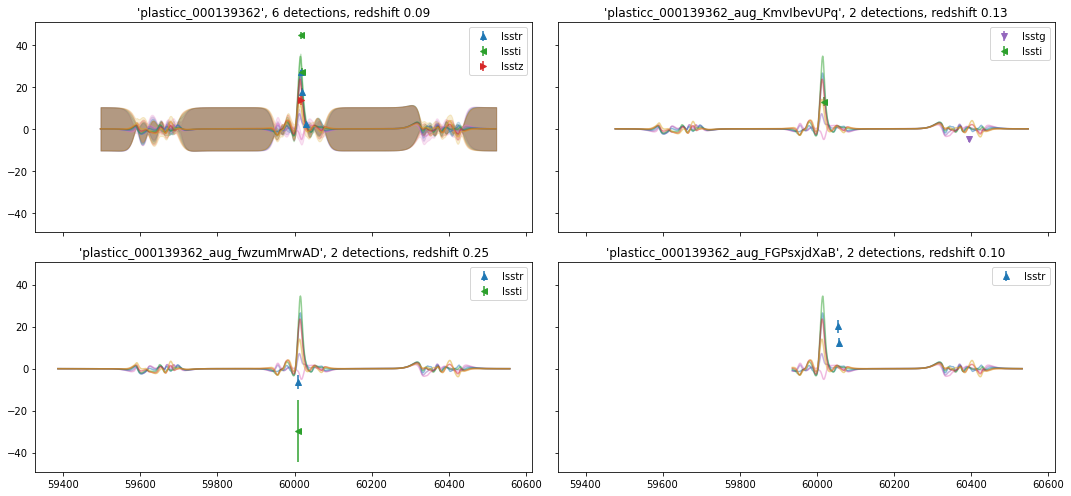

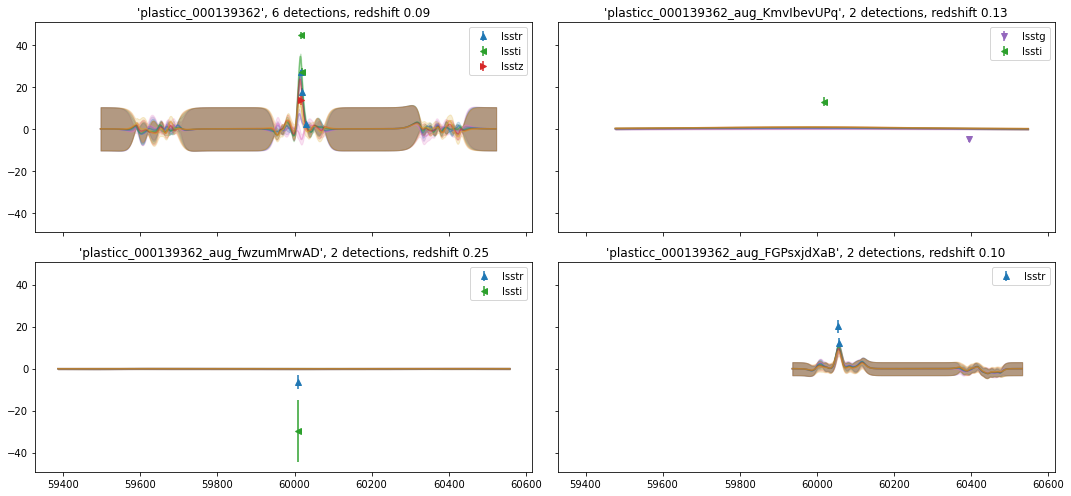

In [31]:
augment_examples(plasticc_train, idxs[1], custom_detections=False)

using num_detections=custom defined by the original time series from where we generate new

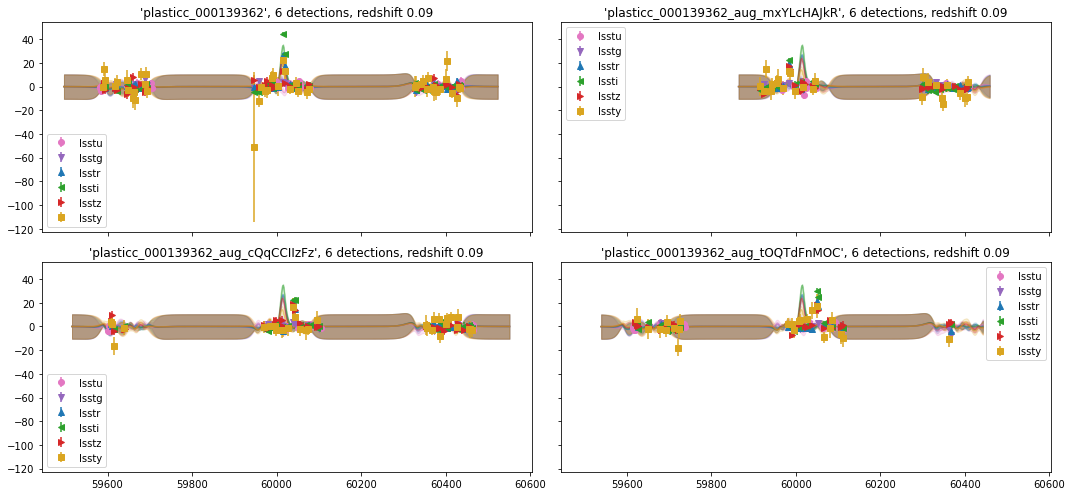

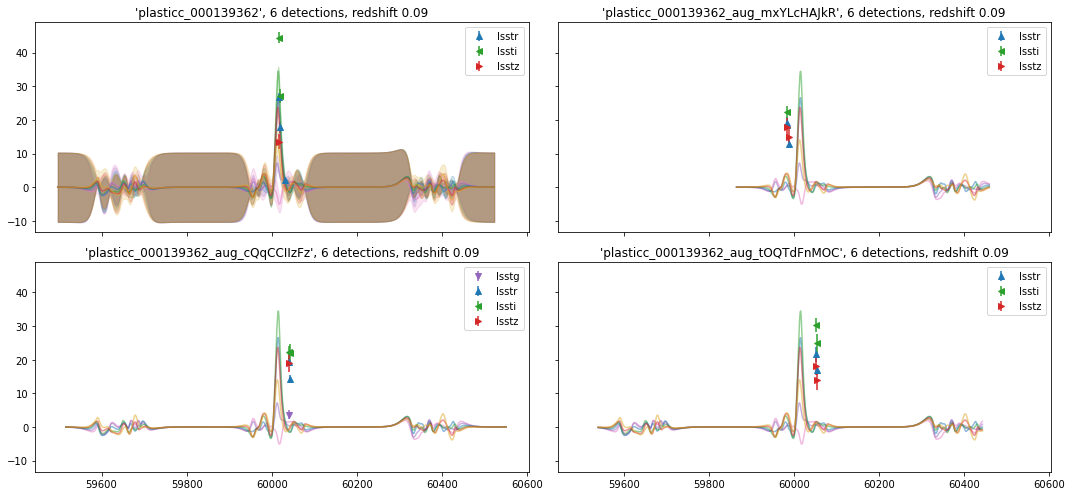

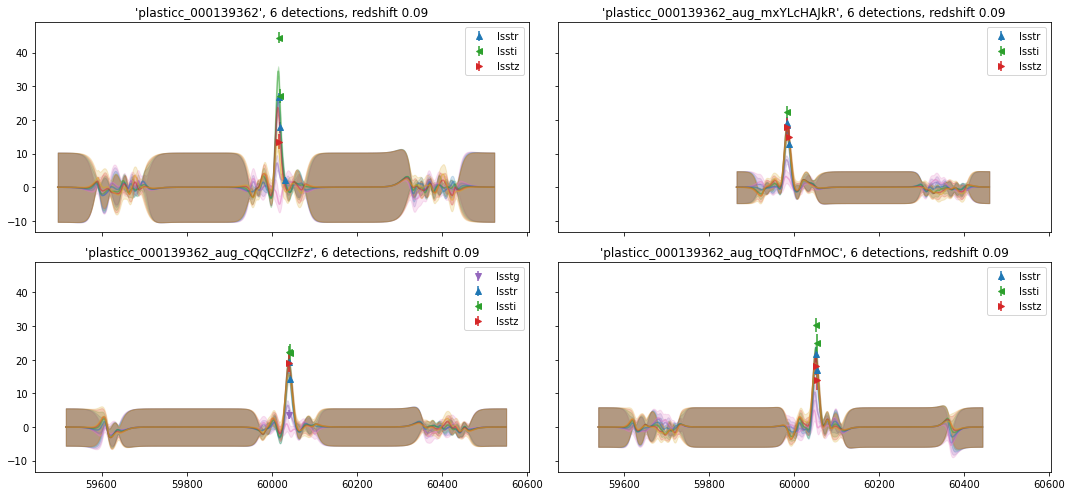

In [32]:
augment_examples(plasticc_train, idxs[1], custom_detections=True)